In [6]:
import sys

moduleLoc = "../"
if moduleLoc in sys.path: 
    print('woo')
else:
    sys.path.append(moduleLoc)
import matplotlib.pyplot as plt
import tools, analysis
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats

# Enable inline plotting
%matplotlib inline

In [4]:
#read tail files into a pd dataframe
import imp
imp.reload(tools)
folderLoc = "/Users/tlsha/Dropbox/NoctData/"
controlName = "siLuc.tails"
KDname = "siNoct.tails"
WTname = "NoctWT.tails"
EAname = "NoctEA.tails"

# Function to read in .tail format file and return a dataframe
control = tools.pdTailMaker(folderLoc+controlName)
print('Control In!')
knockdown = tools.pdTailMaker(folderLoc+KDname)
print('Knockdown In!')
WTaddback = tools.pdTailMaker(folderLoc+WTname)
print('WT In!')
EAaddback = tools.pdTailMaker(folderLoc+EAname)
print('EA In!')

Control In!
Knockdown In!
WT In!
EA In!


In [10]:
# Filter and combine tail data
minTail = -10
maxTail = 10

def filtTails(df, source, minTail, maxTail):
    newDf = df[(df['3Loc']+df['TailLength'])>=minTail]
    newDf = newDf[(newDf['3Loc']+newDf['TailLength'])<=maxTail]
    newDf['Source'] = source
    newDf['TotalTail'] = newDf['3Loc'] + newDf['TailLength']
    return newDf

f_control = filtTails(control, 'siLuc',minTail,maxTail)
f_knockdown = filtTails(knockdown, 'siNoct',minTail,maxTail)
f_WT = filtTails(WTaddback,'WT Addback',minTail,maxTail)
f_EA = filtTails(EAaddback,'EA Addback',minTail,maxTail)


# Combined experimental data
combo = pd.concat([f_control,
                   f_knockdown,
                   f_WT,
                   f_EA],
                  ignore_index=True)

print ("CONTROL\nInitial: {}\nFiltered: {}\n".format(len(control),len(f_control)))
print ("KNOCKDOWN\nInitial: {}\nFiltered: {}\n".format(len(knockdown),len(f_knockdown)))
print ("WT\nInitial: {}\nFiltered: {}\n".format(len(WTaddback),len(f_WT)))
print ("EA\nInitial: {}\nFiltered: {}\n".format(len(EAaddback),len(f_EA)))

combo.set_index('Gene', inplace=True)
combo.to_csv('combo.csv')
combo.head()

CONTROL
Initial: 3903782
Filtered: 1351776

KNOCKDOWN
Initial: 4621080
Filtered: 1324006

WT
Initial: 2411894
Filtered: 759185

EA
Initial: 2579469
Filtered: 779416



,3Loc,TailLength,TailSeq,Type,Source,TotalTail
Gene,,,,,,
RNU1-28P-201,0.0,0.0,,snRNA,siLuc,0.0
RNU1-28P-201,0.0,0.0,,snRNA,siLuc,0.0
RNU1-28P-201,0.0,0.0,,snRNA,siLuc,0.0
RNU1-28P-201,0.0,0.0,,snRNA,siLuc,0.0
RNU1-28P-201,0.0,0.0,,snRNA,siLuc,0.0


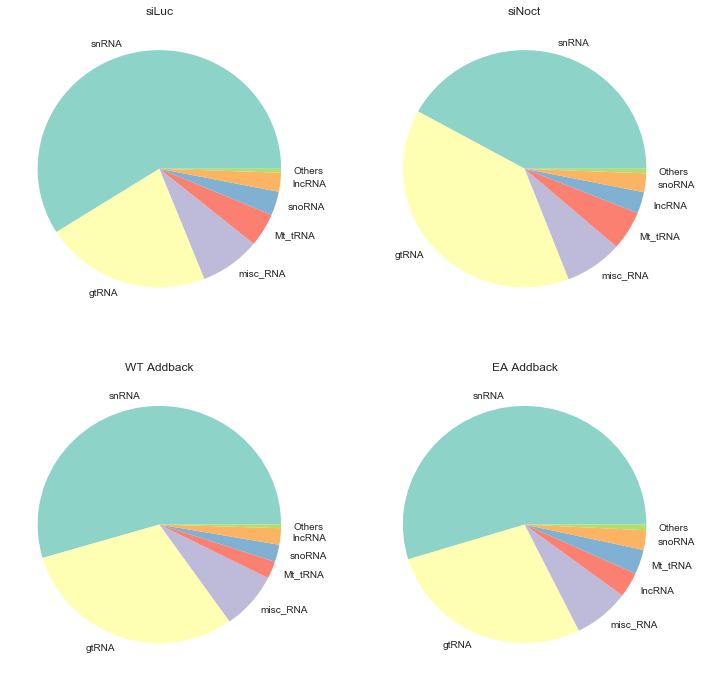

In [11]:
#Plot distribution of mapped reads
f, axarr = plt.subplots(2,2, figsize=(12,12), )
axarr[0,0].set_title("siLuc")
axarr[0,1].set_title("siNoct")
axarr[1,0].set_title("WT Addback")
axarr[1,1].set_title("EA Addback")


def pieMaker (df, column, otheredNum, axis):
    x = list(df[column].value_counts()[:-otheredNum].values)
    others = df[column].value_counts()[-otheredNum:].values
    others = sum(others)
    labels = df[column].value_counts()[:-otheredNum].index.tolist()
    labels += ["Others"]
    colors = sns.color_palette("Set3", 10)
    x +=[others]
    plt.subplot(axis)
    axis = plt.pie(x,labels=labels, colors=colors)

pieMaker(f_control,'Type',4, axarr[0,0])
pieMaker(f_knockdown,'Type',4, axarr[0,1])
pieMaker(f_WT,'Type',4,axarr[1,0])
pieMaker(f_EA,'Type',5,axarr[1,1])


In [57]:
# Create TPM Table and Save to CSV

def TPMmaker(df, source, totalReads):
    df = df.set_index('Gene')
    df.head()
    names = set(df.index)
    out = []
    # 'Gene', 'Source', 'Count', 'TPM'
    for name in names:
        out.append([name,
                    source,
                    df.loc[[name]]['Type'].values[0],
                    len(df.loc[[name]]),
                    len(df.loc[[name]])/(totalReads/1000000)])
    print(source + " finished.")
    return pd.DataFrame(out, columns = ["Gene",'Source','Type','Count','TPM'])

TPM = pd.concat([TPMmaker(f_control,"siLuc",len(control)),
           TPMmaker(f_knockdown, "siNoct", len(knockdown)),
           TPMmaker(f_WT,"WT Addback",len(WTaddback)),
           TPMmaker(f_EA, "EA Addback", len(EAaddback))],
          ignore_index=True)

TPM.to_csv('TPM.csv')

siLuc finished.
siNoct finished.
WT Addback finished.
EA Addback finished.


In [42]:
# Create candidates based on total tail length
df1 = combo[combo['Source']=='siLuc']
df2 = combo[combo['Source']=='siNoct']
df3 = combo[combo['Source']=='WT Addback']
df4 = combo[combo['Source']=='EA Addback']
def findCandidates(df1, df2, pThresh=0.05, minTranscripts=10, minDiff=0.2):
    cans = []
    
    # Build a list of transcripts that are in both sets
    transcripts = list(set(df1.index) & set(df2.index))
    
    i=0
    for tran in transcripts:
        i+=1
        if i%100==0: print(i/len(transcripts))
        df1_reads = df1.loc[[tran],['TotalTail']]
        df2_reads = df2.loc[[tran],['TotalTail']]
        
        #Don't consider reads with less reads than minTranscripts
        if len(df1_reads) < minTranscripts or len(df2_reads) < minTranscripts: continue
        
        #Difference between 2 sets must be statistically significant by at least pThresh by KS test
        p_value = stats.ks_2samp(df1_reads['TotalTail'].values,df2_reads['TotalTail'].values)[1]
        if p_value >pThresh: continue
        
        tran_type = df1.loc[[tran],['Type']].values[0][0]
        df1_count = len(df1_reads.values)
        df1_average = np.average(df1_reads.values)
        df1_stdev = np.std(df1_reads.values)
        df2_count = len(df2_reads.values)
        df2_average = np.average(df2_reads.values)
        df2_stdev = np.std(df2_reads.values)
        
        if abs((df1_average-df2_average)/df1_average) < minDiff: continue

        cans.append([tran,tran_type,df1_count,df1_average,df1_stdev,df2_count,df2_average,df2_stdev,p_value])
    cans = sorted(cans,key=lambda x:x[8])
    return pd.DataFrame(cans, columns = ["Transcript","Transcript Type", "1-Count","1-Average","1-Stdev",
                                        "2-Count","2-Average","2-Stdev","p"]).set_index("Transcript")
        
Luc_Noct_Cans = findCandidates(df1,df2)
Noct_WT_Cans= findCandidates(df2,df3)
WT_EA_Cans= findCandidates(df3,df4)
Luc_EA_Cans= findCandidates(df1,df4)
Luc_WT_Cans= findCandidates(df1,df3)

Luc_Noct_Cans.to_csv('Luc_Noct_Cans.csv')
Noct_WT_Cans.to_csv('Noct_WT_Cans.csv')
WT_EA_Cans.to_csv('WT_EA_Cans.csv')
Luc_EA_Cans.to_csv('Luc_EA_Cans.csv')
Luc_WT_Cans.to_csv('Luc_WT_Cans.csv')


0.12062726176115803
0.24125452352231605
0.3618817852834741
0.4825090470446321
0.6031363088057901
0.7237635705669482
0.8443908323281062
0.9650180940892642
0.13003901170351106
0.26007802340702213
0.39011703511053314
0.5201560468140443
0.6501950585175552
0.7802340702210663
0.9102730819245773
0.1358695652173913
0.2717391304347826
0.4076086956521739
0.5434782608695652
0.6793478260869565
0.8152173913043478
0.9510869565217391
0.13020833333333334
0.2604166666666667
0.390625
0.5208333333333334
0.6510416666666666
0.78125
0.9114583333333334
0.1342281879194631
0.2684563758389262
0.40268456375838924
0.5369127516778524
0.6711409395973155
0.8053691275167785
0.9395973154362416


In [85]:
#Find candidates using TPM, saves candidates based on a maturation hypothesis and a decay hypothesis
matCans = []
decayCans = []
names = list(set(TPM['Gene']))
df1 = TPM[TPM['Source']=='siLuc']
df2 = TPM[TPM['Source']=='siNoct']
df3 = TPM[TPM['Source']=='WT Addback']
df4 = TPM[TPM['Source']=='EA Addback']

for name in names:
    try:
        siLuc = (df1[df1['Gene']==name]['TPM']).values[0]
        siNoct = (df2[df2['Gene']==name]['TPM']).values[0]
        WT = (df3[df3['Gene']==name]['TPM']).values[0]
        EA = (df4[df4['Gene']==name]['TPM']).values[0]
    except:
        continue
    
    #Changes in TPM preicted by different models
    if siLuc > siNoct and siLuc > EA and siNoct < WT and WT > EA: matCans.append([name,siLuc,siNoct,WT,EA])
    if siLuc < siNoct and siLuc < EA and siNoct > WT and WT < EA: decayCans.append([name,siLuc,siNoct,WT,EA])
        
matCans = sorted(matCans, key=lambda x:x[1], reverse=True)
decayCans = sorted(decayCans, key=lambda x:x[1], reverse=True)
        
pd.DataFrame(matCans, columns=['Gene','siLuc','siNoct','WT','EA']).to_csv('Maturation_Candidates.csv')
pd.DataFrame(decayCans, columns=['Gene','siLuc','siNoct','WT','EA']).to_csv('Decay_Candidates.csv')

In [7]:
# Read in from saved CSVs to save hella analysis time. Start from here if you have the CSVs
TPM = pd.read_csv('TPM.csv',index_col=0)
combo = pd.read_csv('combo.csv',index_col=0)

Luc_Noct_Cans = pd.read_csv('Luc_Noct_Cans.csv',index_col=0)
Noct_WT_Cans= pd.read_csv('Noct_WT_Cans.csv',index_col=0)
WT_EA_Cans= pd.read_csv('WT_EA_Cans.csv',index_col=0)
Luc_EA_Cans= pd.read_csv('Luc_EA_Cans.csv',index_col=0)
Luc_WT_Cans= pd.read_csv('Luc_WT_Cans.csv',index_col=0)
can_Arr = [Luc_Noct_Cans,Noct_WT_Cans,WT_EA_Cans,Luc_EA_Cans,Luc_WT_Cans]

mat_cans = pd.read_csv('Maturation_Candidates.csv',index_col=1).drop('Unnamed: 0',axis=1)
dec_cans = pd.read_csv('Decay_Candidates.csv',index_col=1).drop('Unnamed: 0',axis=1)

In [8]:
dec_cans

,siLuc,siNoct,WT,EA
Gene,,,,
Homo_sapiens_tRNA-Glu-CTC-1-7,6308.241598,7960.476772,6070.333108,7487.199885
Metazoa_SRP.45-201,4102.688111,4471.032746,3210.340090,5158.813694
Homo_sapiens_tRNA-Glu-TTC-4-2,1449.363720,1578.851697,1304.783709,1812.000842
Homo_sapiens_tRNA-Asp-GTC-3-1,1411.451767,2778.571243,2578.056913,2867.644465
Homo_sapiens_tRNA-Gly-TCC-3-1,762.849975,1056.462991,900.122476,1017.263631
Homo_sapiens_tRNA-iMet-CAT-1-8,662.690693,807.603417,483.437498,946.706473
AL139099.2-201,653.212705,829.676180,407.563516,1044.788675
Homo_sapiens_tRNA-Lys-CTT-4-1,361.188202,394.496525,362.370817,401.245373
Homo_sapiens_tRNA-Ile-AAT-8-1,348.123947,477.593982,274.887702,350.072050


                               Gene      Source   Type  Count         TPM
323   Homo_sapiens_tRNA-Ile-TAT-2-1       siLuc  gtRNA    593  151.903974
1380  Homo_sapiens_tRNA-Ile-TAT-2-1      siNoct  gtRNA    802  173.552503
2392  Homo_sapiens_tRNA-Ile-TAT-2-1  WT Addback  gtRNA    289  119.822845
3305  Homo_sapiens_tRNA-Ile-TAT-2-1  EA Addback  gtRNA    461  178.718953


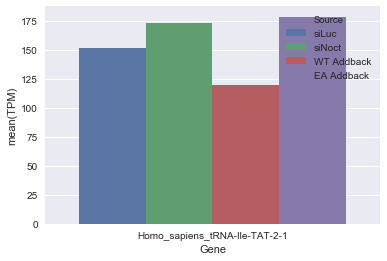

In [48]:
# Plot TPM
def plotTPM(df,transcriptList):
    df = df[df['Gene'].isin(transcriptList)]
    sns.barplot(y='TPM',x='Gene', data=df, hue='Source')
    print(df)
plotTPM(TPM, ["Homo_sapiens_tRNA-Ile-TAT-2-1"])

In [ ]:
# Deprecated code, saved for reference
plt.figure(figsize=(20,20))
df = filtControl[filtControl['Gene'].str.contains('Mt_tRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='blue')

df = filtKD[filtKD['Gene'].str.contains('Mt_tRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='green')

df = filtWT[filtWT['Gene'].str.contains('Mt_tRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='red')

df = filtEA[filtEA['Gene'].str.contains('Mt_tRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='yellow')

#Cumulative plot of mitochondrial tRNA lengths

In [ ]:
# Deprecated code, saved for reference
plt.figure(figsize=(20,20))
df = filtControl[filtControl['Gene'].str.contains('gtRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='blue')

df = filtKD[filtKD['Gene'].str.contains('gtRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='green')

df = filtWT[filtWT['Gene'].str.contains('gtRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='red')

df = filtEA[filtEA['Gene'].str.contains('gtRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='yellow')

#cumulative plots of tRNA

In [2]:
print('blah')

blah
